# LV and LA Segmentation In Echocardiography Images Using U-Net
###### U-Net Paper: <a href="https://arxiv.org/abs/1505.04597">U-Net: Convolutional Networks for Biomedical Image Segmentation</a>
###### Dateset: <a href="http://camus.creatis.insa-lyon.fr/challenge">Cardiac Acquisitions for Multi-structure Ultrasound Segmentation (CAMUS)


## U-Net Architecture

<img src="materials/u-net-architecture.png"/>

<h4>U-Net Architecture has 3 parts:</h4>
<ol>
    <li>The Contracting/Downsampling Path</li>
    <li>Bottleneck</li>
    <li>The Expanding/Upsampling Path</li>
</ol>

<h4>Downsampling Path: </h4> 
<ol>
    <li>It consists of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.</li> 
    <li>At each downsampling step we double the number of feature channels.</li>
</ol>

<h4>Upsampling Path: </h4> 
<ol>
     <li> Every  step  in  the  expansive  path  consists  of  an  upsampling  of  the feature map followed by a 2x2 convolution (“up-convolution”), a concatenation with the correspondingly feature  map  from  the  downsampling  path,  and  two  3x3  convolutions,  each  followed by a ReLU.</li>
</ol>

<h4> Skip Connection: </h4>
The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connection provide local information to global information while upsampling.

<h4> Final Layer: </h4>
At the final layer a 1x1 convolution is used to map each feature vector to the desired number of classes.


## CODE
#### Imports


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import MyUtils
from importlib import reload
import UNet
import pickle

#### User Input Data


In [2]:
path_database = "C:\\Users\\hmral\\PycharmProjects\\Datasets\\CAMUS echocardiography 500 cases\\training"
id_all_data = np.arange(450,dtype=np.uint16) + 1
batch_size = 4
image_shape = (480, 640)
image_masks_names = ('background', 'LVcavity', 'LVmyo', 'LA')
image_masks_index = [{'background':0, 'LVcavity':1, 'LVmyo':2, 'LA':3}[i] for i in image_masks_names]

#### Data Generation


In [3]:
MyUtils = reload(MyUtils)
id_training_data, id_testing_data = MyUtils.split_train_test_id(id_all_data,testing_share=0.2)
training_data = MyUtils.DataGenerator(path_database, id_training_data, batch_size, image_shape, image_masks_index=image_masks_index)
testing_data = MyUtils.DataGenerator(path_database, id_testing_data, batch_size, image_shape, image_masks_index=image_masks_index, shuffle=False)

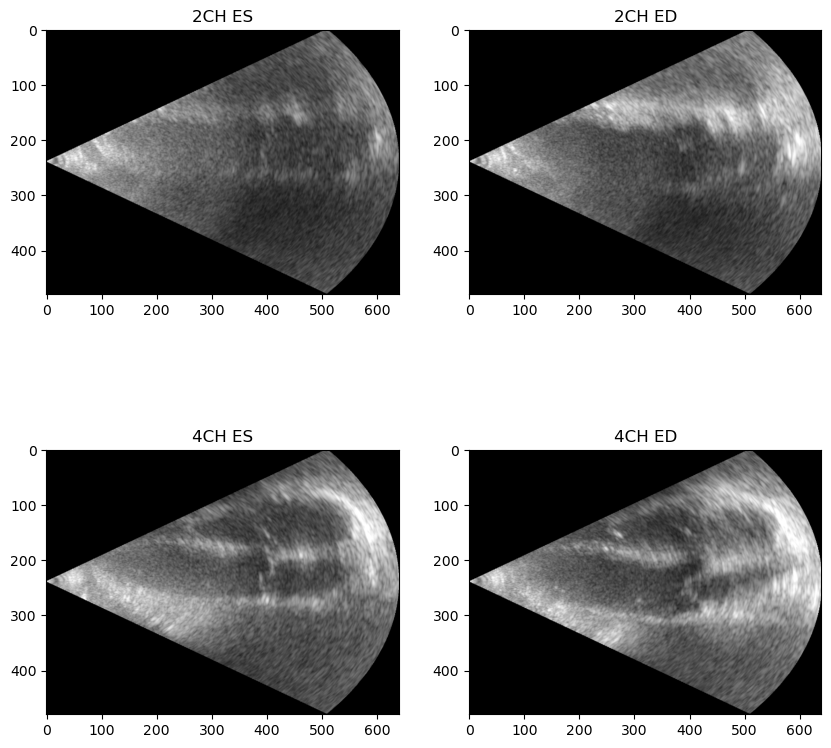

In [4]:
sample_batch_image, sample_batch_mask = training_data.__getitem__(2)
sample_batch_mask = training_data._layers_multi2single(sample_batch_mask)
patient_index_in_batch = 2
title = ('2CH ES', '2CH ED', '4CH ES', '4CH ED')
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
    ax[i//2, i%2].imshow(sample_batch_image[patient_index_in_batch*4+i,:,:,0],cmap='gray')
#     ax[i//2, i%2].imshow(sample_batch_mask[patient_index_in_batch*4+i,:,:,0],cmap='gray',alpha=0.5)
    ax[i//2, i%2].set_title(title[i])

#### Create U-Net


In [5]:
UNet = reload(UNet)
MyUtils = reload(MyUtils)
UNetModel = UNet.create_UNet((None,None,1), (None,None,len(image_masks_index)))
UNetModel.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
# UNetModel.compile(optimizer="adam", loss=MyUtils.dice_coef_loss, metrics=[MyUtils.dice_coef])
UNetModel.summary(line_length=120)

Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_1 (InputLayer)                  [(None, None, None, 1)]    0             []                                      
                                                                                                                        
 conv2d (Conv2D)                       (None, None, None, 4)      40            ['input_1[0][0]']                       
                                                                                                                        
 conv2d_1 (Conv2D)                     (None, None, None, 4)      148           ['conv2d[0][0]']                        
                                                                                                                        
 max_pooling2d (M

In [6]:
UNetModel.fit(training_data, validation_data=testing_data, epochs=10, workers=10)

Epoch 1/10
90/90 [==============================] - 26s 213ms/step - loss: 0.4316 - acc: 0.7559 - val_loss: 0.2810 - val_acc: 0.7557
Epoch 2/10
90/90 [==============================] - 18s 193ms/step - loss: 0.2690 - acc: 0.7588 - val_loss: 0.2776 - val_acc: 0.7557
Epoch 3/10
90/90 [==============================] - 19s 197ms/step - loss: 0.2531 - acc: 0.7588 - val_loss: 0.2426 - val_acc: 0.7557
Epoch 4/10
90/90 [==============================] - 19s 197ms/step - loss: 0.2377 - acc: 0.7588 - val_loss: 0.2343 - val_acc: 0.7557
Epoch 5/10
90/90 [==============================] - 19s 197ms/step - loss: 0.2208 - acc: 0.7585 - val_loss: 0.2148 - val_acc: 0.7557
Epoch 6/10
90/90 [==============================] - 19s 197ms/step - loss: 0.2100 - acc: 0.7589 - val_loss: 0.2070 - val_acc: 0.7560
Epoch 7/10
90/90 [==============================] - 19s 196ms/step - loss: 0.1998 - acc: 0.7616 - val_loss: 0.1908 - val_acc: 0.7665
Epoch 8/10
90/90 [==============================] - 19s 198ms/step - 

In [7]:
UNetModel.save_weights('UNetModel_weights.h5')

In [8]:
UNetModel.load_weights('UNetModel_weights.h5')

In [9]:
sample_test_image, sample_test_mask = testing_data.__getitem__(5)
sample_test_image = sample_test_image[:4]
sample_test_mask = testing_data._layers_multi2single(sample_test_mask[:4])
predict_segment = UNetModel.predict(sample_test_image)
predict_segment = (predict_segment>0.5).astype(np.uint8)
predict_segment = testing_data._layers_multi2single(predict_segment)

1/1 [==============================] - 1s 663ms/step


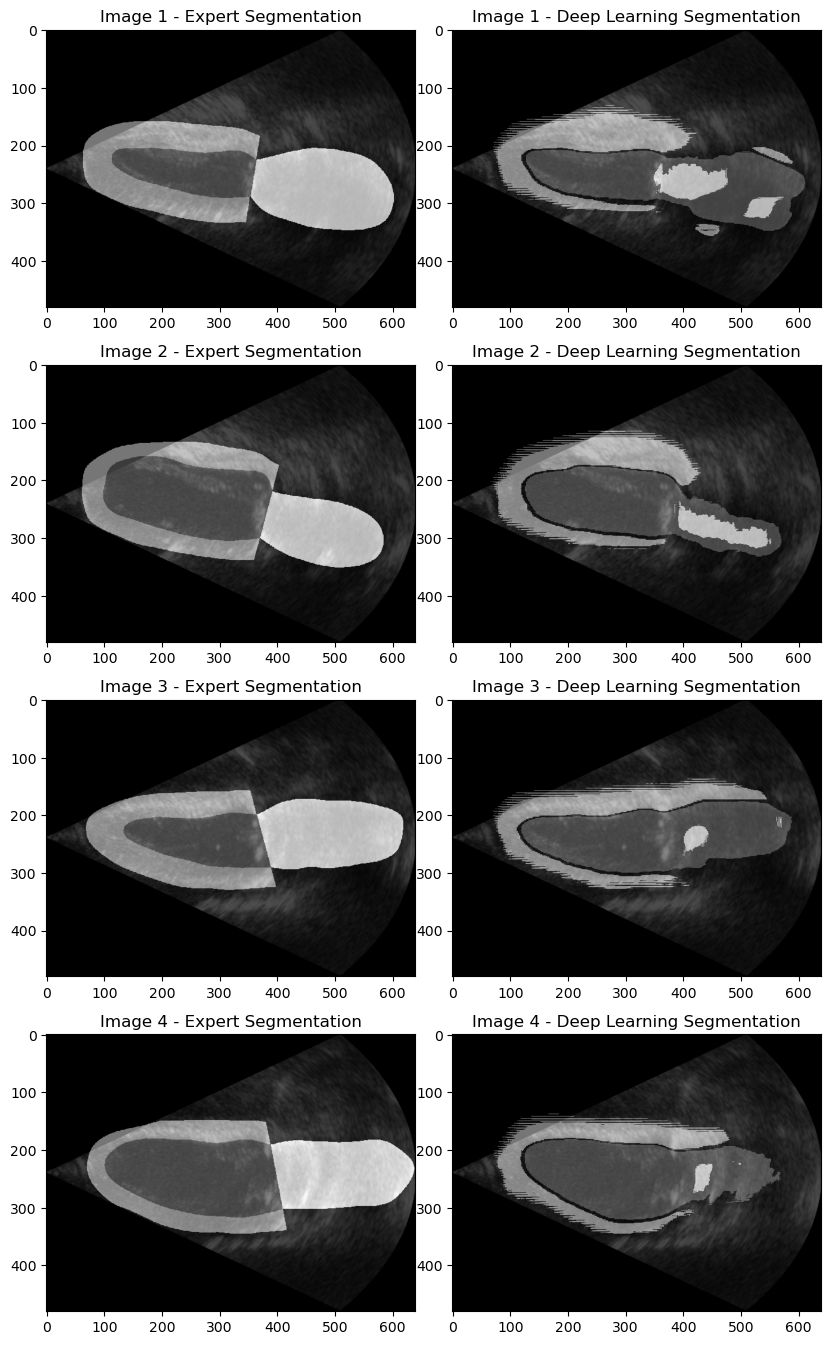

In [10]:
fig, axs = plt.subplots(sample_test_image.shape[0], 2, figsize=(10,17))
for i in range(sample_test_image.shape[0]):
    axs[i,0].imshow(sample_test_image[i,:,:,0], cmap='gray')
    axs[i,0].imshow(sample_test_mask[i,:,:,0],cmap='gray',alpha=0.7)
    axs[i,0].set_title("Image %d - Expert Segmentation" % (i+1))
    axs[i,1].imshow(sample_test_image[i,:,:,0], cmap='gray')
    axs[i,1].imshow(predict_segment[i,:,:,0],cmap='gray',alpha=0.7)
    axs[i,1].set_title("Image %d - Deep Learning Segmentation" % (i+1))
plt.subplots_adjust(hspace=0.1, wspace=0.1)